In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [3]:
!pip install seaborn



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input



In [7]:
# Define the TRAIN folder path
data_dir = 'dataset2-master/images/TRAIN'

# Define the class labels
class_labels = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

# Store file paths and labels
filepaths = []
labels = []

# Loop through each class folder
for label in class_labels:
    class_folder = os.path.join(data_dir, label)
    for file in os.listdir(class_folder):
        if file.endswith('.jpeg') or file.endswith('.png'):
            filepaths.append(os.path.join(class_folder, file))
            labels.append(label)

# Create a DataFrame
bloodCell_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Shuffle the DataFrame
bloodCell_df = bloodCell_df.sample(frac=1).reset_index(drop=True)

# Show top 5 entries
bloodCell_df.head()


,filepaths,labels
0,dataset2-master/images/TRAIN\monocyte\_4_375.jpeg,monocyte
1,dataset2-master/images/TRAIN\eosinophil\_25_32...,eosinophil
2,dataset2-master/images/TRAIN\eosinophil\_7_374...,eosinophil
3,dataset2-master/images/TRAIN\eosinophil\_57_34...,eosinophil
4,dataset2-master/images/TRAIN\neutrophil\_105_7...,neutrophil


In [8]:
# Define the TRAIN folder path
data_dir = 'dataset2-master/images/TRAIN'

# Define the class labels
class_labels = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

# Store file paths and labels
filepaths = []
labels = []

# Loop through each class folder
for label in class_labels:
    class_folder = os.path.join(data_dir, label)
    for file in os.listdir(class_folder):
        if file.endswith('.jpeg') or file.endswith('.png'):
            filepaths.append(os.path.join(class_folder, file))
            labels.append(label)

# Create a DataFrame
bloodCell_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Shuffle the DataFrame
bloodCell_df = bloodCell_df.sample(frac=1).reset_index(drop=True)

# Show top 5 entries
bloodCell_df.head()


,filepaths,labels
0,dataset2-master/images/TRAIN\lymphocyte\_1_59....,lymphocyte
1,dataset2-master/images/TRAIN\neutrophil\_37_68...,neutrophil
2,dataset2-master/images/TRAIN\lymphocyte\_15_69...,lymphocyte
3,dataset2-master/images/TRAIN\eosinophil\_36_46...,eosinophil
4,dataset2-master/images/TRAIN\lymphocyte\_18_17...,lymphocyte


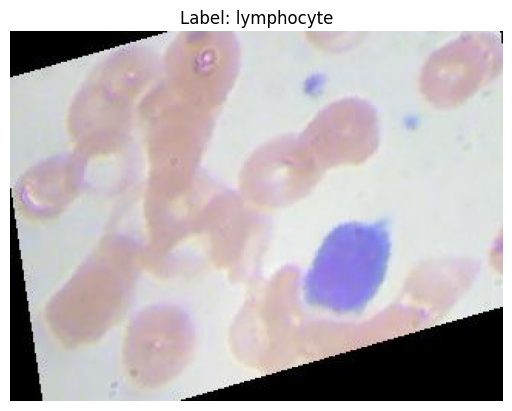

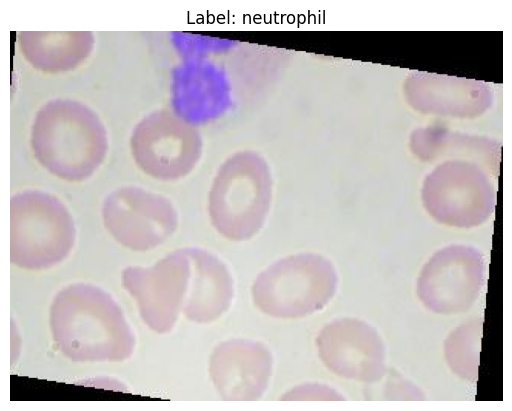

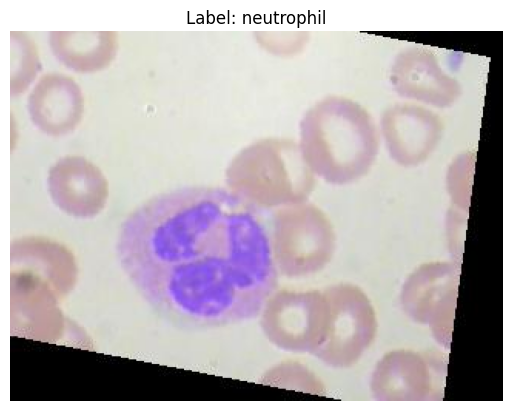

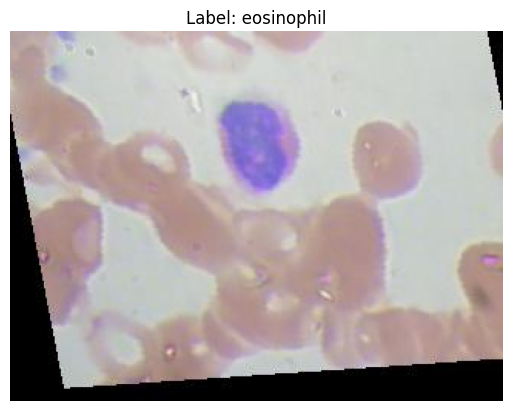

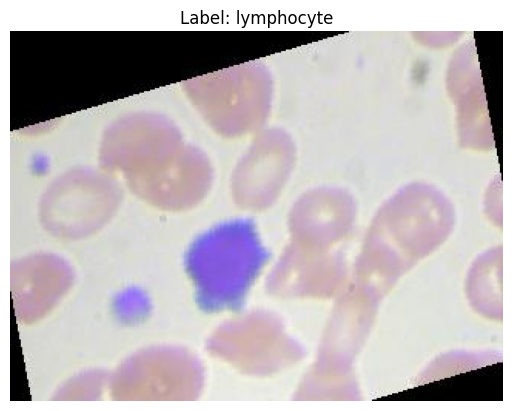

In [9]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Show 5 random images
for i in range(5):
    img_path = random.choice(bloodCell_df['filepaths'])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Label: {bloodCell_df[bloodCell_df['filepaths'] == img_path]['labels'].values[0]}")
    plt.axis('off')
    plt.show()


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Create training and validation generators with augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # 80% training, 20% validation
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

# Define image size and batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data
train_generator = datagen.flow_from_directory(
    directory='dataset2-master/images/TRAIN',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data
val_generator = datagen.flow_from_directory(
    directory='dataset2-master/images/TRAIN',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.


In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base (without top)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers (don’t train them)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer        │ (None, 224, 224, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ Conv1 (Conv2D)     │ (None, 112, 112, │       864 │ input_layer[0][… │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ bn_Conv1           │ (None, 112, 112, │       128 │ Conv1[0][0]      │
│ (BatchNormalizati… │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ Conv1_relu (ReLU)  │ (None, 112, 112, │         0 │ bn_Conv1[0][0]   │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ expanded_conv_dep… │ (None, 112, 112, │       288 │ Conv1_relu[0][0] │
│ (DepthwiseConv2D)  │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ expanded_conv_dep… │ (None, 112, 112, │       128 │ expanded_conv_d… │
│ (BatchNormalizati… │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ expanded_conv_dep… │ (None, 112, 112, │         0 │ expanded_conv_d… │
│ (ReLU)             │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ expanded_conv_pro… │ (None, 112, 112, │       512 │ expanded_conv_d… │
│ (Conv2D)           │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ expanded_conv_pro… │ (None, 112, 112, │        64 │ expanded_conv_p… │
│ (BatchNormalizati… │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_expand     │ (None, 112, 112, │     1,536 │ expanded_conv_p… │
│ (Conv2D)           │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_expand_BN  │ (None, 112, 112, │       384 │ block_1_expand[… │
│ (BatchNormalizati… │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_expand_re… │ (None, 112, 112, │         0 │ block_1_expand_… │
│ (ReLU)             │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_pad        │ (None, 113, 113, │         0 │ block_1_expand_… │
│ (ZeroPadding2D)    │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_depthwise  │ (None, 56, 56,   │       864 │ block_1_pad[0][… │
│ (DepthwiseConv2D)  │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_depthwise… │ (None, 56, 56,   │       384 │ block_1_depthwi… │
│ (BatchNormalizati… │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_depthwise… │ (None, 56, 56,   │         0 │ block_1_depthwi… │
│ (ReLU)             │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_project    │ (None, 56, 56,   │     2,304 │ block_1_depthwi… │
│ (Conv2D)           │ 24)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_project_BN │ (None, 56, 56,   │        96 │ bloc

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # Start with 10; you can increase to 15–20 later
)


C:\Users\balas\OneDrive\Desktop\HematoVision\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.3381 - loss: 1.4446 - val_accuracy: 0.5631 - val_loss: 1.0608
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.5136 - loss: 1.1227 - val_accuracy: 0.6405 - val_loss: 0.9167
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.5864 - loss: 0.9869 - val_accuracy: 0.6486 - val_loss: 0.8513
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.6195 - loss: 0.9177 - val_accuracy: 0.6973 - val_loss: 0.7817
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.6330 - loss: 0.8798 - val_accuracy: 0.7134 - val_loss: 0.7518
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.6560 - loss: 0.8380 - val_accuracy: 0.7416 - val_loss: 0.6964
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.6675 - loss: 0.8218 - val_accuracy: 0.7325 - val_loss: 0.6912
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4113s 11s/step - accuracy: 0.6728 - loss: 0.7967 - val_ac

In [17]:
model.save("BloodCell.h5")


63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step

Classification Report:

              precision    recall  f1-score   support

  eosinophil       0.22      0.20      0.21       499
  lymphocyte       0.23      0.25      0.24       496
    monocyte       0.25      0.30      0.27       495
  neutrophil       0.24      0.21      0.23       499

    accuracy                           0.24      1989
   macro avg       0.24      0.24      0.24      1989
weighted avg       0.24      0.24      0.24      1989



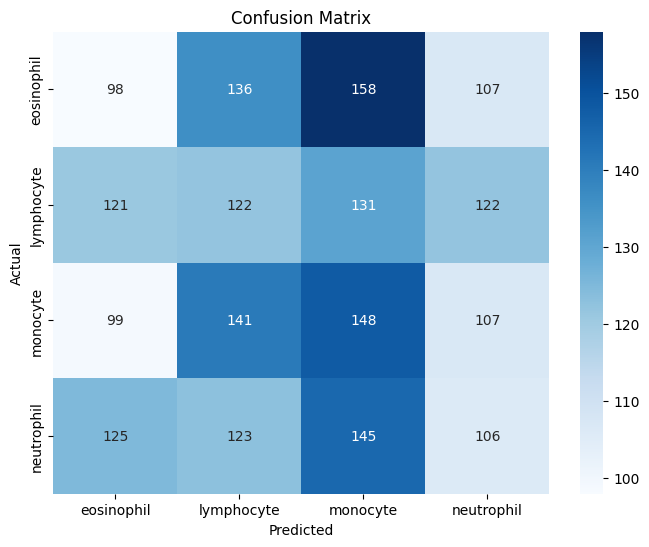

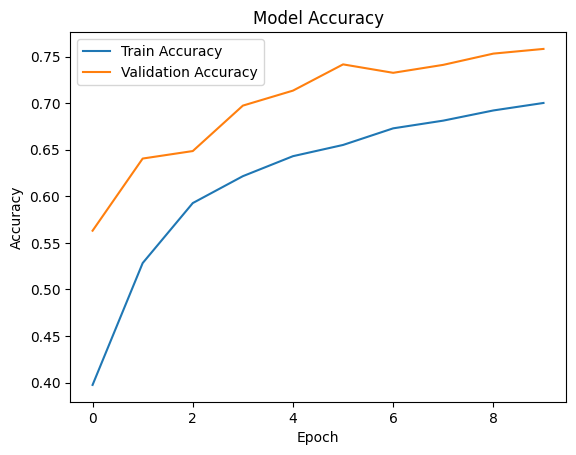

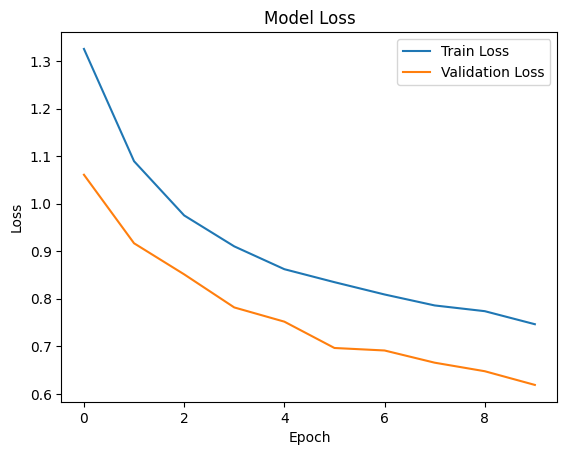

In [21]:
# ✅ Evaluation: Confusion Matrix + Classification Report + Accuracy/Loss Plots

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Step 1: Reset the validation generator
val_generator.reset()

# Step 2: Predict labels
predictions = model.predict(val_generator)
pred_labels = np.argmax(predictions, axis=1)
true_labels = val_generator.classes

# Step 3: Classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_labels))

# Step 4: Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 5: Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Step 6: Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
